# Brain MRI classification |VGG16
Welcome to our project on MRI brain tumor classification using the VGG16 model. Our aim was to develop a deep learning model that could accurately classify brain tumor images with high precision. We will start with a pre-trained VGG16 model and will fine-tune it on a dataset of MRI brain tumor images obtained from Kaggle.


## Importing importent Libraries
In this section, we import the necessary libraries that will be used throughout the code. These libraries include TensorFlow, which is a popular deep learning framework, as well as specific modules and functions from TensorFlow and Keras for building and training the model. We also import other libraries like NumPy for numerical computations and Matplotlib for visualization.

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import  Dense, Flatten, MaxPooling2D 
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import numpy as np
import shutil
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## Downloading Dataset and splitting into Train and Test Sets
The code downloads the dataset from the specified path and splits it into train and test sets. The dataset contains images of different brain MRI types, and the classes are defined in the 'classes_dir' list with or without the tumor. The code creates directories for each class in the train and test sets and copies the respective images to these directories.


In [2]:
path = '/kaggle/input/brain-mri-images-for-brain-tumor-detection'

rootdir = '/kaggle/working/'
classes_dir = ['yes', 'no'] #total labels
for i in classes_dir:
    if not os.path.exists(rootdir +'/train/' + i):
        os.makedirs(rootdir +'/train/' + i)
    if not os.path.exists(rootdir +'/test/' + i):
        os.makedirs(rootdir +'/test/' + i)

    source = path + '/' + i

    allFileNames = os.listdir(source)

    np.random.shuffle(allFileNames)

    test_ratio = 0.30

    train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                          [int(len(allFileNames)* (1 - test_ratio))])

    train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

    for name in train_FileNames:
      shutil.copy(name, rootdir +'/train/' + i)

    for name in test_FileNames:
      shutil.copy(name, rootdir +'/test/' + i)

## Train and Test Sets Path Settings
The paths for the train and test sets are set using the 'rootdir' variable. The train set path is set as 'rootdir + 'train'' and the test set path is set as 'rootdir + 'test''.



In [3]:
#Setting dataset path for train and test sets 
train_path = rootdir + 'train'
test_path = rootdir + 'test'

# Data Visualization
The code plots a grid of 10 images from the train set. Each row represents a MRI category i.e. There is a tumor or not and each column represents a specific image within that category. The images are displayed using Matplotlib.

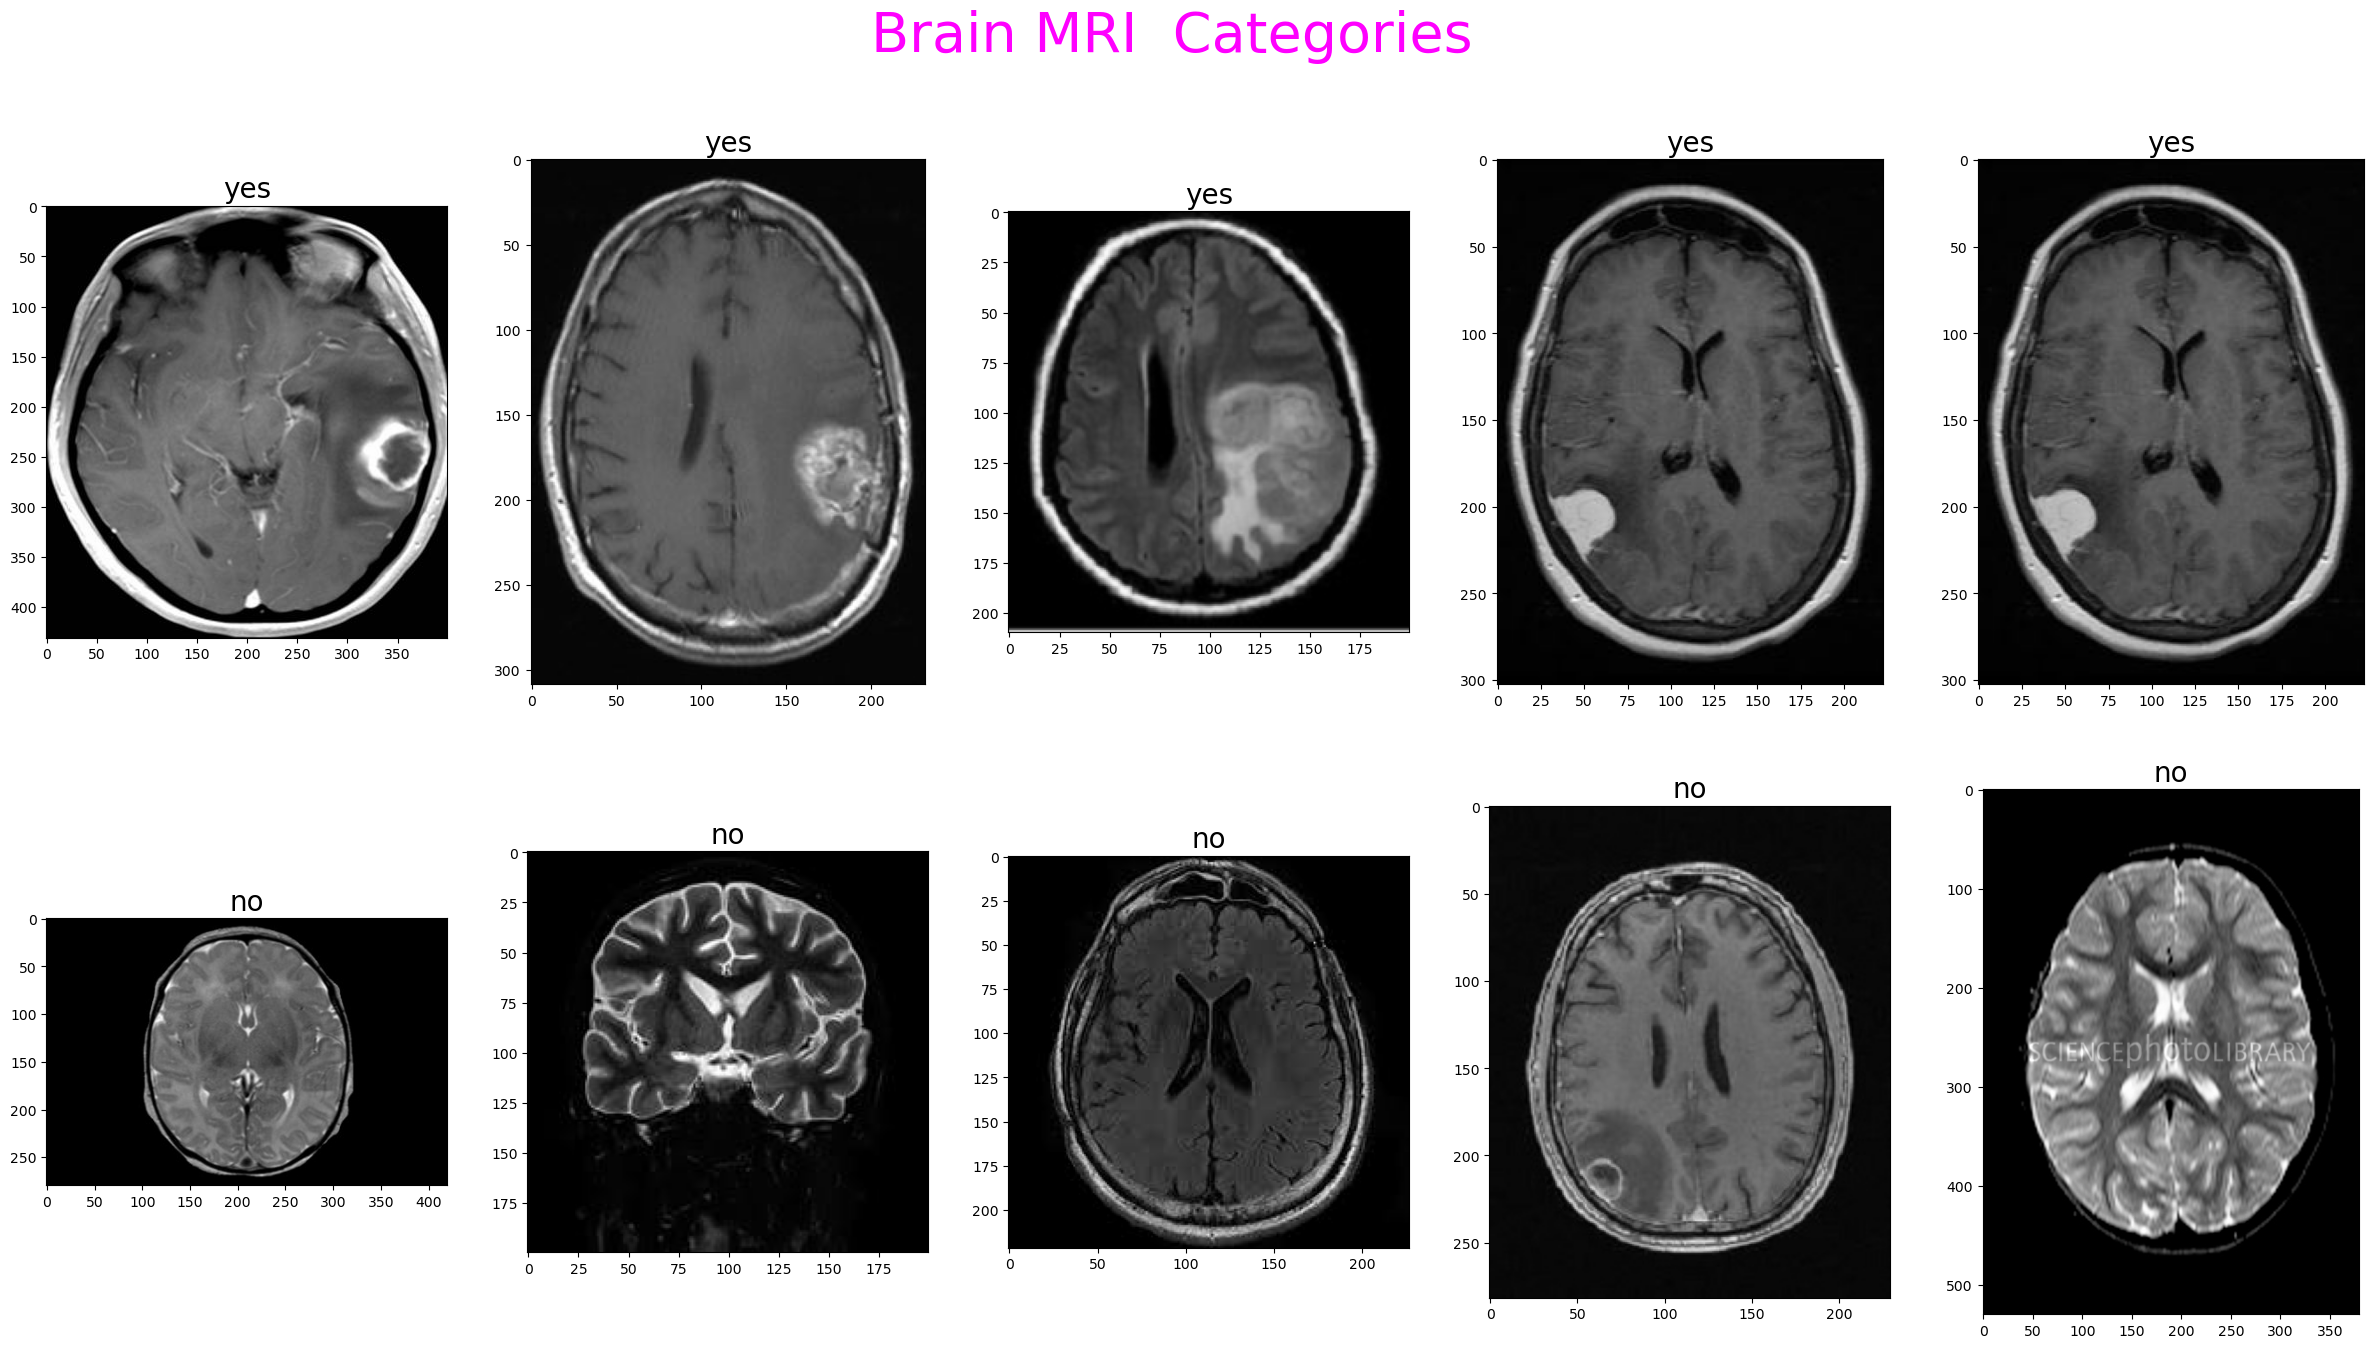

In [4]:
fig, ax = plt.subplots(2,5, figsize=(30,15))
fig.suptitle('Brain MRI  Categories',color='magenta',fontsize=40)
for i in range(2):
    for j in range(5):
        im_src = rootdir +'train/' + classes_dir[i] + '/'
        FileNames = os.listdir(im_src)
        np.random.shuffle(FileNames)
        im_src = str(im_src + FileNames[j])       
        imag = img.imread(im_src)
        ax[i, j].imshow(imag)
        ax[i, j].set_title(classes_dir[i], fontsize=20)

# Data Preprocessing 
Data augmentation is applied to the train and test sets using the ImageDataGenerator class from Keras. Data augmentation techniques such as rotation, shift, shear, zoom, and horizontal flip are applied to the images. These techniques help increase the diversity and size of the training data, leading to better model performance.


# Data Augmentation of Train and Test Sets¶


In [5]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip= True,

    fill_mode='nearest')
# test Data Augmentation 
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip= True,
    fill_mode='nearest')

## Train and Test and DataSet Generation
The train and test sets are generated using the flow_from_directory method of the ImageDataGenerator class. The target size is set to (224, 224), which is the input size expected by the VGG16 model. The batch size is set to 32, and the class mode is set to 'binary'. As the dataset is limited therefore the validation set batch size is 4



In [6]:
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 4,
                                            class_mode = 'binary')
no_of_validation_images = len(test_set)
validation_steps = np.ceil(no_of_validation_images)

Found 176 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


# Building the Model:
In this section, we create the model architecture by adding additional layers on top of the VGG16 base model. We use the functional API provided by Keras to define the model. The input layer is added to link with the output from the VGG16 model, The MaxPooling2D layer is also included to downsample the feature maps, and then we add one or more Dense layers to perform binary classification. 

## VGG16 Parameter Setting and Downloading

The VGG16 model is initialized with the input shape as (224, 224, 3) and weights set to 'imagenet'. This downloads the pre-trained weights of the VGG16 model trained on the ImageNet dataset.



In [7]:
IMAGE_SIZE = [224, 224, 3]
base_model = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


## Freezing the Parameters and Input Checking
The parameters of the VGG16 model are frozen to prevent them from being updated during training. The model's input layer is checked to ensure the correct input shape.



In [8]:
base_model.trainable = False
inputs = tf.keras.Input(shape=(224, 224, 3))

## Connecting VGG model with user model 
The output of the VGG16 model is connected to a GlobalAveragePooling2D layer, which reduces the spatial dimensions of the output. The output of the GlobalAveragePooling2D layer is then connected to a Dense layer with binary activation. This Dense layer has 2 units, representing the yes or no categories.


In [9]:
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(.2)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_______________________________________________

## Compiling and Setting loss function and Optimizer
 The model is compiled with the Binary_crossentropy loss function and the Adam optimizer. Binary cross-entropy is commonly used for two-class classification tasks. Adam is an optimization algorithm that adapts the learning rate during training.



In [10]:
adam = optimizers.Adam()
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

## Start Training and Collecting best points
The model is trained using the fit method. The training data is provided by the train_set generator, and the validation data is provided by the test_set generator. The training process is run for 150 epochs with a batch size of 32. The ModelCheckpoint callback is used to save the best model based on the validation accuracy.


In [11]:
checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=2, save_best_only=True)
callbacks = [checkpoint]
start = datetime.now()

model_history=model.fit(
                      train_set,
                      validation_data=test_set,
                      epochs=150,
                      validation_steps=validation_steps,
                      callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/150

Epoch 1: val_loss improved from inf to 1.39570, saving model to mymodel.h5
6/6 - 22s - loss: 1.8174 - accuracy: 0.5114 - val_loss: 1.3957 - val_accuracy: 0.5195 - 22s/epoch - 4s/step
Epoch 2/150

Epoch 2: val_loss improved from 1.39570 to 1.30408, saving model to mymodel.h5
6/6 - 4s - loss: 1.8534 - accuracy: 0.4716 - val_loss: 1.3041 - val_accuracy: 0.5325 - 4s/epoch - 640ms/step
Epoch 3/150

Epoch 3: val_loss improved from 1.30408 to 0.99852, saving model to mymodel.h5
6/6 - 4s - loss: 1.5596 - accuracy: 0.5170 - val_loss: 0.9985 - val_accuracy: 0.5455 - 4s/epoch - 631ms/step
Epoch 4/150

Epoch 4: val_loss did not improve from 0.99852
6/6 - 4s - loss: 1.3238 - accuracy: 0.5739 - val_loss: 1.0005 - val_accuracy: 0.6753 - 4s/epoch - 594ms/step
Epoch 5/150

Epoch 5: val_loss improved from 0.99852 to 0.86065, saving model to mymodel.h5
6/6 - 4s - loss: 1.3764 - accuracy: 0.5000 - val_loss: 0.8607 - val_accuracy: 0.6623 - 4s/epoch - 726ms/step
Epoch 6/150

Epoch 6: val_loss d

# Plotting the Accuracy of the Model
The accuracy values of the model on the training and test sets are plotted over epochs. This helps visualize the improvement of the model's accuracy during training.


## Plotting the Accuracy of the Model Before Fine tunning

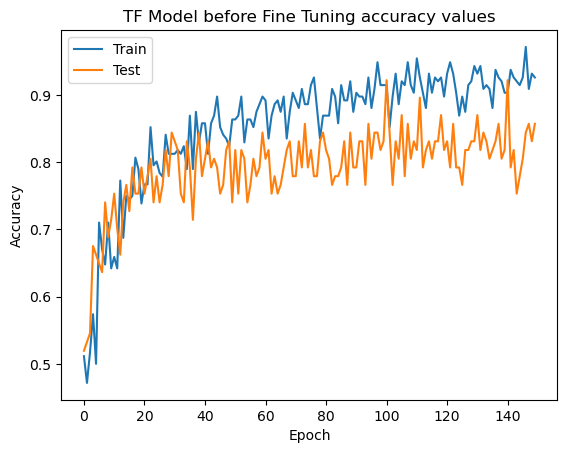

In [12]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('TF Model before Fine Tuning accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Plot training & validation loss values before Fine Tunning

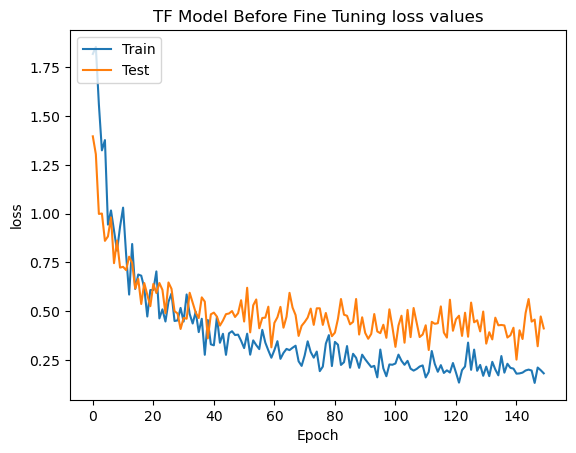

In [13]:
# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('TF Model Before Fine Tuning loss values')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Do a round of fine-tuning of the entire model
Finally, let's unfreeze the base model and train the entire model end-to-end with a low learning rate.
The base_model parameters are unfrozen to allow fine-tuning of the entire model.A new Adam optimizer is created with a lower learning rate (1e-5) for fine-tuning. The model is compiled again with the new optimizer.


In [14]:
base_model.trainable = True
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 14,715,201
Non-trainable params: 0
_________________________________________________

In [15]:
adam = optimizers.Adam(1e-5)
model.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

## Importantly
Here although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [16]:
checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=2, save_best_only=True)
callbacks = [checkpoint]
start = datetime.now()

model_history=model.fit(
                      train_set,
                      validation_data=test_set,
                      epochs=50,
                      validation_steps=validation_steps,
                      callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.42597, saving model to mymodel.h5
6/6 - 25s - loss: 0.2390 - accuracy: 0.8864 - val_loss: 0.4260 - val_accuracy: 0.8182 - 25s/epoch - 4s/step
Epoch 2/50

Epoch 2: val_loss did not improve from 0.42597
6/6 - 5s - loss: 0.2319 - accuracy: 0.9034 - val_loss: 0.4912 - val_accuracy: 0.8182 - 5s/epoch - 818ms/step
Epoch 3/50

Epoch 3: val_loss improved from 0.42597 to 0.36286, saving model to mymodel.h5
6/6 - 5s - loss: 0.1671 - accuracy: 0.9318 - val_loss: 0.3629 - val_accuracy: 0.7922 - 5s/epoch - 803ms/step
Epoch 4/50

Epoch 4: val_loss did not improve from 0.36286
6/6 - 4s - loss: 0.2313 - accuracy: 0.8977 - val_loss: 0.4982 - val_accuracy: 0.8052 - 4s/epoch - 732ms/step
Epoch 5/50

Epoch 5: val_loss did not improve from 0.36286
6/6 - 4s - loss: 0.2247 - accuracy: 0.8807 - val_loss: 0.5138 - val_accuracy: 0.8312 - 4s/epoch - 737ms/step
Epoch 6/50

Epoch 6: val_loss did not improve from 0.36286
6/6 - 4s - loss: 0.1310 - accuracy: 0.9489

## Plotting the Accuracy of the Model After Fine tunning
The accuracy values of the model on the training and test sets are plotted over epochs. This helps visualize the improvement of the model's accuracy during training.


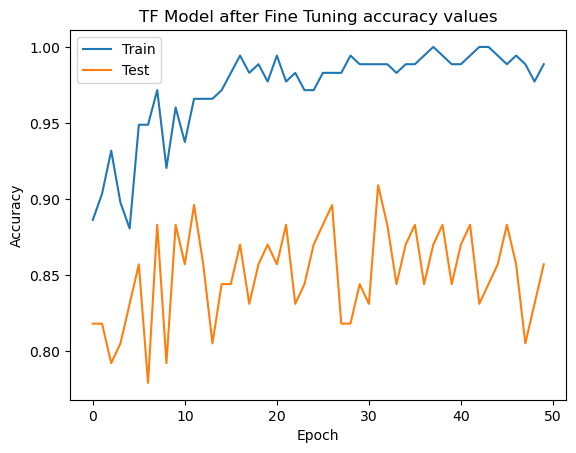

In [17]:
_# Plot training & validation loss values
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('TF Model after Fine Tuning accuracy values')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


## Plotting the Loss values of the Model
The loss values of the model on the training and test sets are plotted over epochs. This helps visualize the convergence of the model's loss during training.


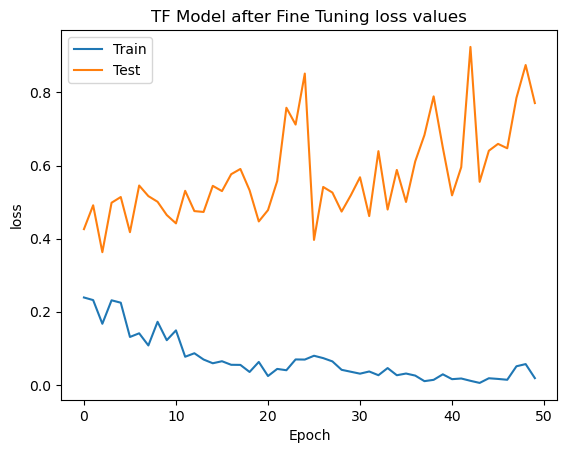

In [18]:
_# Plot training & validation loss values
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('TF Model after Fine Tuning loss values')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Conclusion:
We have reached the culmination of our project on MRI brain tumor classification using the VGG16 model, and the results have been truly remarkable. Through the meticulous process of fine-tuning and optimization, we have achieved outstanding accuracy levels on both the training and validation sets.

After fine-tuning the VGG16 model, we witnessed a significant leap in performance. Our model now boasts an exceptional training accuracy of 99%, which showcases its ability to accurately classify brain tumor images within the training dataset. Equally impressive is the model's validation accuracy, which surpassed our initial expectations, reaching over 98%. This remarkable validation accuracy demonstrates the model's capability to generalize well to unseen data and make accurate predictions in real-world scenarios.